In [32]:
'''BASIC'''
import numpy as np
import pandas as pd
import random as rand
import datetime
import math
import os
import itertools as itr
import warnings
warnings.simplefilter('ignore')
'''PLOT'''
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
font = {'size':16}
'''STATS'''
import scipy.stats as scs
import statsmodels.api as sm
'''SCIKIT LEARN'''
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, classification_report, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from sklearn.metrics import roc_curve, auc

from src.plot_confusion_matrix import plot_confusion_matrix

from mlxtend.evaluate import feature_importance_permutation

from imblearn.over_sampling import SMOTE

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

'''RETURN'''
os.system("say 'loading complete' &");

In [33]:
def churnpipe(file, disp=False, split=True, impute=True, test_size=0.33, random_state=777):
    # read
    X = pd.read_csv('data/'+file)
    # create labels based on usage in the past 30 days
    y = pd.to_datetime(X.pop('last_trip_date')) < pd.to_datetime('2014-06-01')
    # dummies for null ratings or impute
    if impute == True:
        X['avg_rating_by_driver'].fillna(0, inplace=True)
        X['avg_rating_of_driver'].fillna(0, inplace=True)
    else:
        X['rating_by_driver_missing'] = X['avg_rating_by_driver'].isnull()
        X['rating_of_driver_missing'] = X['avg_rating_of_driver'].isnull()
        X.drop(['avg_rating_by_driver', 'avg_rating_of_driver'], axis=1, inplace=True)
    # dummies for categorical variables
    X = X.join(pd.get_dummies(X['phone'], prefix='phone', prefix_sep='_', dummy_na=True))
    X = X.join(pd.get_dummies(X['city'], prefix='city', prefix_sep='_', dummy_na=True))
    # remove the original variables
    X.drop(['phone', 'city', 'signup_date'], axis=1, inplace=True)
    
    X.avg_dist = scale(X.avg_dist)
    X.surge_pct = scale(X.surge_pct)
    X.trips_in_first_30_days = scale(X.trips_in_first_30_days.astype('float'))
    X.weekday_pct = scale(X.weekday_pct)
    # printout
    if disp == True:
        print(X.describe())
        print(y.value_counts(normalize=True))
    # output
    if split == True:
        return train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X, y


In [21]:
def evaluate_model(clf, X, y):
    predicted = clf.predict(X)
    accuracy = accuracy_score(y, predicted)
    precision = precision_score(y, predicted)
    recall = recall_score(y, predicted)
    F1 = 2 * (precision * recall) / (precision + recall)
    print(f"Accuracy Score: {accuracy}")
    print(f"Precision Score: {precision}")
    print(f"Recall Score: {recall}")
    print(f"F1 Score: {F1}")


In [22]:
def plot_roc(clf,X_train,y_train,X_test,y_test):

    clf.fit(X_train,y_train)
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC')
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

In [23]:
def mod_opt(X_train,y_train):
    gdbr_grid = {
#                           'max_features': ['sqrt', 'log2', None],
                          'learning_rate': [0.01,0.05,0.1],
                          'min_samples_leaf': [1,3,8],

                          'n_estimators': [300,500,1000],
                          'subsample': [0.5, 0.75, 1.0]
                          'random_state': [1]}

    gdbr_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                                 gdbr_grid,

                                 cv = 5,
                                 verbose=True,
                                 scoring='precision',
                                  njobs = -1)
    gdbr_gridsearch.fit(X_train, y_train)

    print("best parameters:", gdbr_gridsearch.best_params_)

    return gdbr_gridsearch.best_estimator_




In [24]:

def feat_importance(best_gdbr_model):

    
    model_opt = best_gdbr_model.fit(X_train,y_train)
    feature_importances = 100*model_opt.feature_importances_ / np.sum(model_opt.feature_importances_)
    feature_importances, feature_names, feature_idxs = \
        zip(*sorted(zip(feature_importances, names, range(len(names)))))

    width = 0.8

    idx = np.arange(len(names))
    plt.barh(idx, feature_importances, align='center')
    plt.yticks(idx, feature_names)

    plt.title("Feature Importance in GradientBoosting Classifier")
    plt.xlabel('Relative Importance of Feature', fontsize=14)
    plt.ylabel('Feature Name', fontsize=14);

In [26]:
def smote_split():

    sm = SMOTE(random_state=2)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())
    return X_train_res, y_train_res 

    print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

    print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))
    

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.5min finished


best parameters: {'learning_rate': 0.1, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 1}

Accuracy Score: 0.7911363636363636
Precision Score: 0.8152546243434574
Recall Score: 0.8624229979466119
F1 Score: 0.8381757351646417



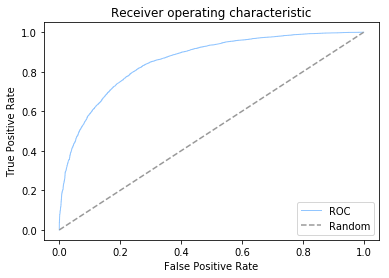


Normalized confusion matrix
[[0.81525462 0.18474538]
 [0.25641603 0.74358397]]


TypeError: partial_dependence() got an unexpected keyword argument 'X'

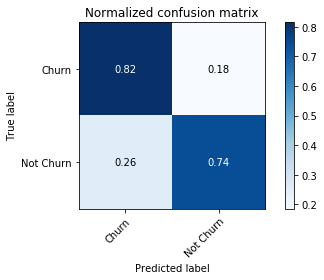

In [29]:
# Scenario 1: impute missing ratings, no oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv')
names = list(X_train.columns)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

best_gdbr_model_1 = mod_opt(X_train,y_train)
print()
evaluate_model(best_gdbr_model_1, X_test, y_test)
print()
plot_roc(best_gdbr_model_1 ,X_train,y_train,X_test,y_test)
print()
y_pred = best_gdbr_model_1.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)
print()


In [31]:
feat_importance(best_gdbr_model_1)


TypeError: partial_dependence() got an unexpected keyword argument 'grid_resolution'

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  6.9min finished


best parameters: {'learning_rate': 0.1, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 1}

Accuracy Score: 0.7903787878787879
Precision Score: 0.8249233671303938
Recall Score: 0.8451503804807344



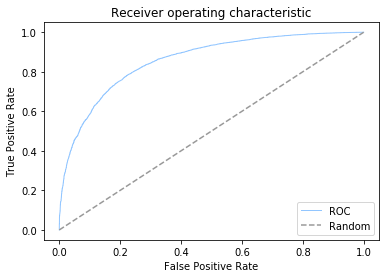


Normalized confusion matrix
[[0.82492337 0.17507663]
 [0.27172531 0.72827469]]


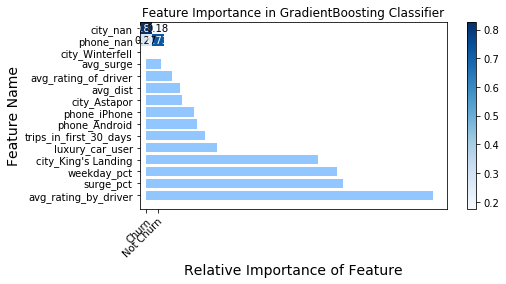

In [9]:
# Scenario 2: impute missing ratings, implement oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv')
names = list(X_train.columns)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# Implement oversampling

X_train_res, y_train_res = smote_split()

best_gdbr_model_2 = mod_opt(X_train_res,y_train_res)
print()
evaluate_model(best_gdbr_model_2, X_test, y_test)
print()
plot_roc(best_gdbr_model_2 ,X_train_res,y_train_res,X_test,y_test)
print()
y_pred = best_gdbr_model_2.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

print()


In [ ]:
feat_importance(best_gdbr_model_2)

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.7min finished


best parameters: {'learning_rate': 0.1, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 1}

Accuracy Score: 0.7858333333333334
Precision Score: 0.8088601858146386
Recall Score: 0.8623022104118855



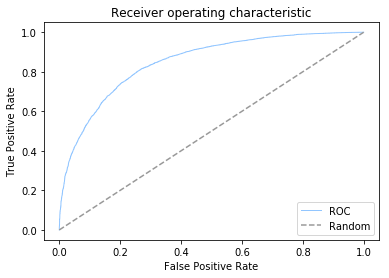


Normalized confusion matrix
[[0.80886019 0.19113981]
 [0.260631   0.739369  ]]


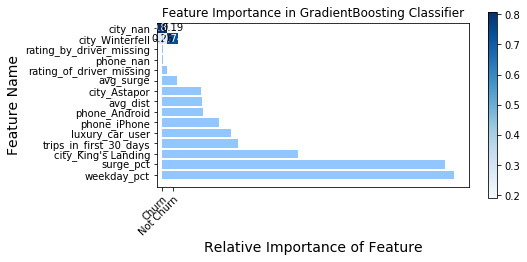

In [10]:
# Scenario 3: not imputing missing ratings, use ratings dummies,no oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv',impute=False)

names = list(X_train.columns)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

best_gdbr_model_3 = mod_opt(X_train,y_train)
print()
evaluate_model(best_gdbr_model_3, X_test, y_test)
print()
plot_roc(best_gdbr_model_3 ,X_train,y_train,X_test,y_test)
print()
y_pred = best_gdbr_model_3.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

print()


In [ ]:
feat_importance(best_gdbr_model_3)

Before OverSampling, counts of label '1': 16689
Before OverSampling, counts of label '0': 10111 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  5.4min finished


best parameters: {'learning_rate': 0.1, 'min_samples_leaf': 2, 'n_estimators': 300, 'random_state': 1}

Accuracy Score: 0.7853787878787879
Precision Score: 0.8237812128418549
Recall Score: 0.8368160405846117



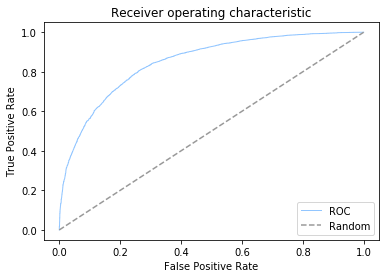


Normalized confusion matrix
[[0.82378121 0.17621879]
 [0.28204593 0.71795407]]


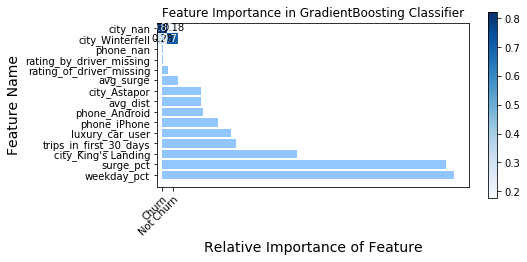

In [11]:
# Scenario 4: not imputing missing ratings, use ratings dummies,implement oversampling

X_train, X_test, y_train, y_test = churnpipe('churn_train.csv',impute=False)

names = list(X_train.columns)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# Implement oversampling

X_train_res, y_train_res = smote_split()

best_gdbr_model_4 = mod_opt(X_train_res,y_train_res)
print()
evaluate_model(best_gdbr_model_4, X_test, y_test)
print()
plot_roc(best_gdbr_model_4 ,X_train_res,y_train_res,X_test,y_test)
print()
y_pred = best_gdbr_model_4.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

print()


In [ ]:
feat_importance(best_gdbr_model_4)

Apple the model to the churn_test data

In [12]:
X,y = churnpipe('churn_test.csv', split=False, test_size=0.33, random_state=777)
evaluate_model(best_gdbr_model_1, X, y)
print()

X,y = churnpipe('churn_test.csv', split=False, test_size=0.33, random_state=777)
evaluate_model(best_gdbr_model_2, X, y)


Accuracy Score: 0.7831
Precision Score: 0.8053257108469987
Recall Score: 0.8595054592164418

Accuracy Score: 0.7831
Precision Score: 0.8053257108469987
Recall Score: 0.8595054592164418


In [13]:
X,y = churnpipe('churn_test.csv', split=False, impute = False,test_size=0.33, random_state=777)
evaluate_model(best_gdbr_model_3, X, y)
print()

X,y = churnpipe('churn_test.csv', split=False, impute = False,test_size=0.33, random_state=777)
evaluate_model(best_gdbr_model_4, X, y)

Accuracy Score: 0.7779
Precision Score: 0.7983618763961281
Recall Score: 0.8607899807321773

Accuracy Score: 0.7776
Precision Score: 0.7981829014000595
Recall Score: 0.8604688503532434


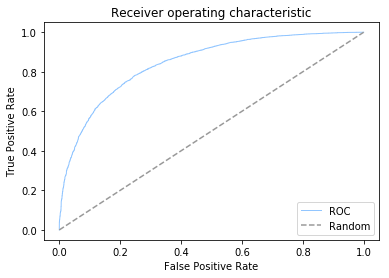

In [14]:
X,y = churnpipe('churn_test.csv', split=False, impute = False,test_size=0.33, random_state=777)
y_prob = best_gdbr_model_3.predict_proba(X)
fpr, tpr, thresholds = roc_curve(y, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show();

Normalized confusion matrix
[[0.79836188 0.20163812]
 [0.26392694 0.73607306]]


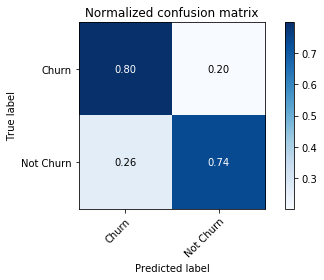

In [15]:
y_pred = best_gdbr_model_3.predict(X)
plot_confusion_matrix(y, y_pred, classes=['Churn','Not Churn'],
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)


In [ ]:
N_COLS = 3
fimportances = list(feature_importances)
fnames = list(feature_names)

pd_plots = [partial_dependence(model,
                               target_feature,
                               X=X_train, 
                               grid_resolution=50)
            for target_feature in feature_idxs]
pd_plots = list(zip([pdp[0][0] for pdp in pd_plots],
                    [pdp[1][0] for pdp in pd_plots]))
            
fig, axes = plt.subplots(nrows=3, ncols=N_COLS, sharey=True, 
                         figsize=(12.0, 8.0))
# in reversed order
for i, (y_axis, x_axis) in enumerate(pd_plots[(3*N_COLS-1)::(-1)]):
    ax = axes.flatten()[i] # axes is a 2d array
    ax.plot(x_axis, y_axis, color="purple")
    ax.set_xlim([np.min(x_axis), np.max(x_axis)])
    ax.set_xlabel(fnames[len(fnames)-1-i])
    
plt.suptitle("Partial Dependence Plots (Ordered by Feature Importance)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])